# Generative Deep Learning: Autoencoder

## Original by Joseph Gesnouin

Make sure the notebook uses the GPU available in google collab: “Execution -> change execution type -> GPU”.

### Introduction

In this tutorial, you will learn how to use Auto-encoders (dense, CNN, VAE) and GANS to generate new training instances via deep unsupervised learning.

In [1]:
# !pip install -U tensorflow[and-cuda]==2.17

In [2]:
import os

In [3]:
import tensorflow as tf

2024-11-15 15:50:49.384758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 15:50:49.615601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731657049.705010    1643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731657049.731824    1643 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 15:50:49.936521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
device_name = tf.test.gpu_device_name()
# You may want to uncomment below if running on Colab or on a computer that has an nVidia GPU
# if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1731657052.782141    1643 gpu_device.cc:2022] Created device /device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# !pip install keras==3.4.1

In [6]:
# !pip install scikit-learn

In [7]:
#%%capture
# !pip install seaborn

In [8]:
# !pip install numpy==1.26.4

In [9]:
import urllib.request
import os
def download(url, filename):
    # download with check if file exists already
    if os.path.isfile(filename):
        return
    urllib.request.urlretrieve(url,filename)

In [10]:
# download('https://cloud.minesparis.psl.eu/index.php/s/8za58r5j87WXlZZ/download','imgaug-master.zip')

In [11]:
from zipfile import ZipFile
import os
def unzip(filename, dest_path = None):
    # unzips a zip file in the folder of the notebook to the notebook
    with ZipFile(filename, 'r') as zObject: 
        # Extracting all the members of the zip  
        # into a specific location. a
        if dest_path is None:
            zObject.extractall(path=os.getcwd())
        else:
            zObject.extractall(path=dest_path)

In [12]:
#%%capture 
# unzip("imgaug-master.zip")
# !pip install -e imgaug-master

In [13]:
# Uncomment below if running on Colab
#%tensorflow_version 2.x

import tensorflow as tf
device_name = tf.test.gpu_device_name()
# You may want to uncomment below if running on Colab or on a computer that has an nVidia GPU
# if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.random.set_seed(42)

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import fashion_mnist
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, BatchNormalization, Flatten, Conv2DTranspose, Reshape,concatenate
import keras
from sklearn.model_selection import train_test_split
import os 
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
np.random.seed(37)
import random as rn
rn.seed(1254)
import tensorflow as tf
tf.random.set_seed(0)

#from tensorflow.compat.v1.keras import backend as K
from tensorflow.python.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

print("[INFO] loading Fashion MNIST...")
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_x = train_images.reshape(-1, 28, 28, 1)
test_x = test_images.reshape(-1, 28, 28, 1)
train_y = train_labels
test_y = test_labels

###on travaille sur le test set directement car plus petit: histoire que le notebook tourne en entier pendant la durée du TP
train_x = test_x
train_y = test_y

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)


## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

## normalize and reshape the predictors  
train_x = train_x / 255
val_x = val_x / 255


I0000 00:00:1731657052.833367    1643 gpu_device.cc:2022] Created device /device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Found GPU at: /device:GPU:0


I0000 00:00:1731657053.265453    1643 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


[INFO] loading Fashion MNIST...


### We're working here on the FashionMnist dataset, which contains 70,000 images in 10 categories. The images show Zalando clothing, in low resolution (28 x 28 pixels).

To ensure that the TP runs fast enough, we'll concentrate on a subset of the dataset.

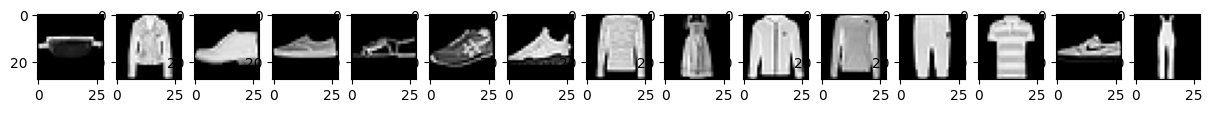

In [14]:
from PIL import Image 
import matplotlib.pyplot as plt
f, ax = plt.subplots(1,15)
f.set_size_inches(15, 40)
for i in range(15):
    ax[i].imshow(train_x[i].reshape(28, 28),cmap='gray')
plt.show()

# Part 1: Classic auto-encoders (dense and CNN)



An **AutoEncoder** takes input data with a very high dimensionality and runs it through a neural network. It will try to compress the data into a smaller representation.





![](https://i.imgur.com/9PrT1KA.png)



It works in two stages





* The first is what can be considered the encoding stage: the encoder corresponds to a cluster of layers (fully connected, convolutional, recurrent, etc.) which will take the input and compress it until a smaller representation is obtained: this is the bottleneck.

* From the bottleneck, the second part corresponds to an attempt to reconstruct the initial data.



The greater the number of dimensions in the latent space, the clearer and more robust the reconstructions.



The cost function of an AE simply consists of reconstructing the initial dataset and calculating the reconstruction loss with respect to the input. In its most basic form, the optimal solution of an AE is strongly related to the PCA:



To calculate the values of the hidden layers, we simply multiply the weights between the input and the layer, giving us the following formula:



z = f(Wx)



To obtain the output, we multiply the weights between the hidden layers and the output by the value of the hidden layers:



y = g(Vz)



the functions f and g are free, as long as they are non-linear and can be derived for backpropagation. We thus obtain the following function:



y = g(V(f(Wx)) = VWx



giving us the objective function:


![](https://i.imgur.com/HLH7ZhO.png)



This corresponds to the PCA objective function. However, the autoencoder is far more flexible than the PCA: each layer has an activation function (Relu, tanh, sigmoid...) enabling us to introduce the notion of non-linearity, unlike the PCA, which can only represent linear transformations. With appropriate dimensionality and parsimony constraints, AEs can therefore learn more interesting data projections than PCA, and they can also be stacked...



Let's move on to deep learning methods for dimension reduction: auto-encoders (Dense and CNN).



In [15]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


A dense, multi-layer deep autoencoder:

## If the previous cell lists an error with Numa you can solve it in the following way under Linux. In other OS it hopefully does work.
1. Check if there is an issue with Numa. Execute in a terminal
   
`cat /sys/bus/pci/devices/0000\:01\:00.0/numa_node`

2. If the output is -1 fix it as follows:

`sudo echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:01\:00.0/numa_node`

In [30]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(512, activation='relu')(input_layer)
encode_layer1 = BatchNormalization()(encode_layer1)
encode_layer2 = Dense(256, activation='relu')(encode_layer1)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer2 = Dense(128, activation='relu')(encode_layer2)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer2 = Dense(64, activation='relu')(encode_layer2)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer3 = Dense(32, activation='relu')(encode_layer2)
encode_layer3 = BatchNormalization()(encode_layer3)

## latent view
latent_view   = Dense(32, activation='sigmoid',name="latent")(encode_layer3)
direct_input = Input(shape=(32,))


## decoding architecture
decode_layer1 = Dense(32, activation='relu')(direct_input)
decode_layer1 = BatchNormalization()(decode_layer1)
decode_layer2 = Dense(64, activation='relu')(decode_layer1)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer2 = Dense(128, activation='relu')(decode_layer2)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer2 = Dense(256, activation='relu')(decode_layer2)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer3 = Dense(512, activation='relu')(decode_layer2)
decode_layer3 = BatchNormalization()(decode_layer3)

## output layer
output_layer  = Dense(784)(decode_layer3)

encoder = Model(input_layer, latent_view)
decoder = Model(direct_input, output_layer)
model = Model(input_layer, decoder(latent_view))

In [31]:
model.summary()
decoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 784)            │       582,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,163,760 (4.44 MB)

 Trainable params: 1,159,792 (4.42 MB)

 Non-trainable params: 3,968 (15.50 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,256 (2.22 MB)

 Trainable params: 580,272 (2.21 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [32]:
## reshape the inputs
train_x = train_x.reshape(-1, 784)
test_x = val_x.reshape(-1, 784)

model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=100, batch_size=32, validation_data=(test_x, test_x), callbacks=[early_stopping,reduce_lr], shuffle=True)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2317 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0369 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0332 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0323 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0313 - val_loss: 0.0287 - learning_rate: 0.0010
E

In [33]:
preds = model.predict(test_x)
preds_latent = encoder.predict(test_x)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Let's look at the reconstruction of our dense autoencoder: Our autoencoder works by mapping images from a 784-dimensional space (28 x 28 x 1) to a space of dimension 10 (latent image). The compression ratio is 80. The decoder works by reconfiguring the resulting latent image into a space of initial dimension 784 (note that a decoder works a bit like a GAN generator).

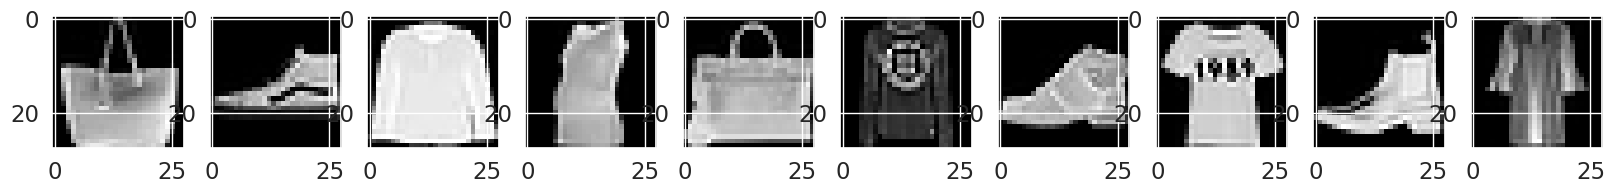

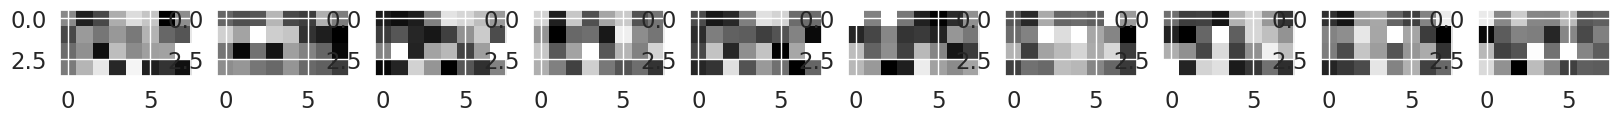

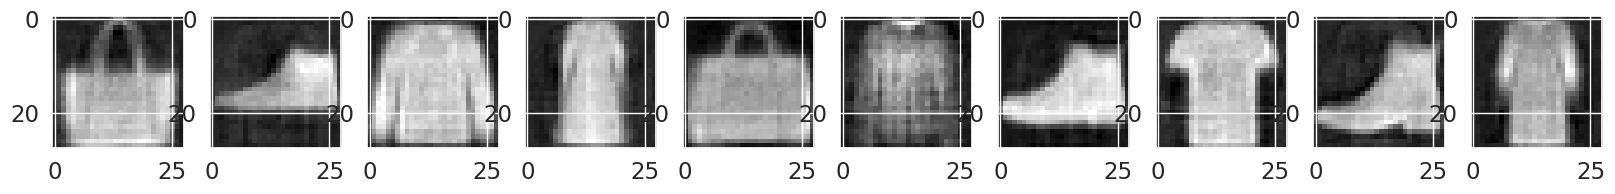

In [35]:
#images originales
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(test_x[i].reshape(28, 28),cmap='gray')
plt.show()

#visualisation du latent space
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds_latent[i].reshape(4, 8),cmap='gray')
plt.show()

#visualisation
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28),cmap='gray')
plt.show()

Let's now visualize the latent space of dimension 10 in a space of dimension 2 obtained by T-SNE: to visualize what a latent space looks like.

In [36]:
from sklearn.manifold import TSNE

preds_latent = encoder.predict(train_x)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(preds_latent)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.174760
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.659431
[t-SNE] KL divergence after 300 iterations: 3.356354


In [37]:
# Utility function
lab = ["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle boot"]

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(lab[i]), fontsize=25)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 [Text(-7.121221542358398, -4.754499912261963, 't-shirt'),
  Text(0.7450923919677734, -9.766047477722168, 'trouser'),
  Text(-5.324995517730713, 3.192751884460449, 'pullover'),
  Text(-0.6406335234642029, -4.9810967445373535, 'dress'),
  Text(-6.518874168395996, 1.66585373878479, 'coat'),
  Text(5.433358192443848, -0.19572748243808746, 'sandal'),
  Text(-4.366304397583008, 0.787277102470398, 'shirt'),
  Text(9.568805694580078, -0.8975648880004883, 'sneaker'),
  Text(0.4085235297679901, 6.360953330993652, 'bag'),
  Text(6.164906978607178, 7.013328552246094, 'ankle boot')])

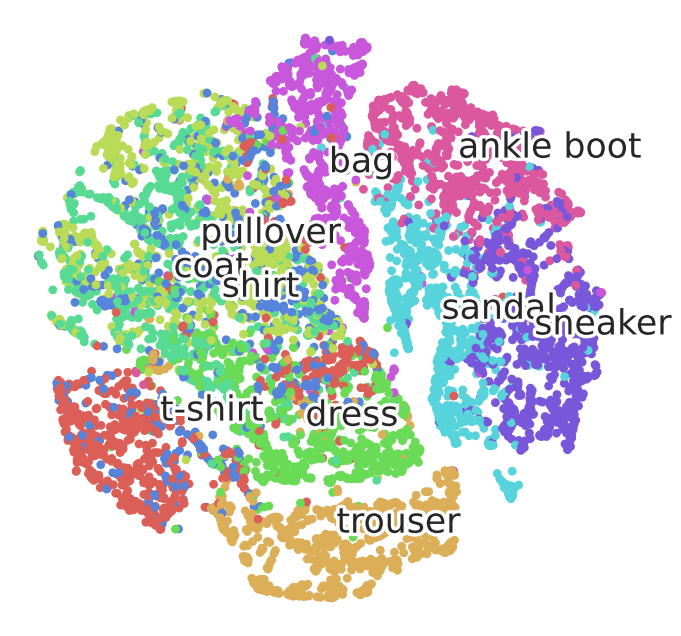

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

Here, we have fixed the size of the latent space (10 dimensions). If we were to map all 60,000 FashionMnist images into latent space, each of the 10 classes in the dataset would cluster into a 10-dimensional hyperellipsoid. You can have fun drastically increasing the size of the latent space to get better results.

You can already see that the clusters for each class are fairly coherent: shoes are on one side (sandal, sneaker, ankle boot), bags and pants are fairly well separated from the other examples, and upper-body garments (those with the least inter-class variance) remain fairly clustered.

If we wish to generate a new image of a certain class, we can choose a new random point (different from the points of existing images) inside the ellipsoid of a class and then decode it.

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


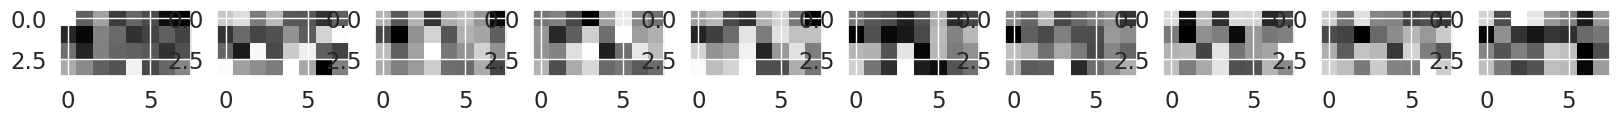

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


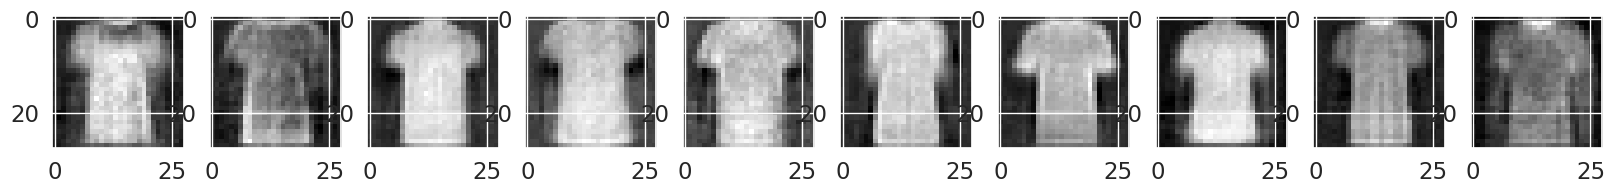

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


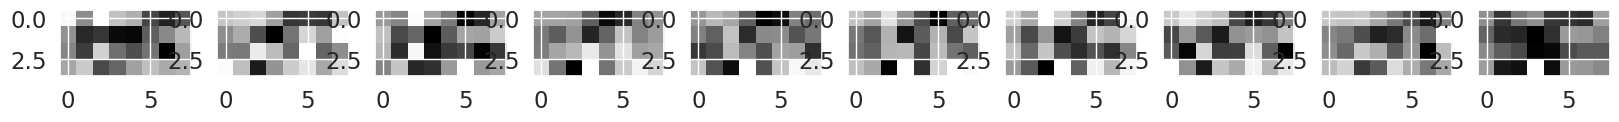

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


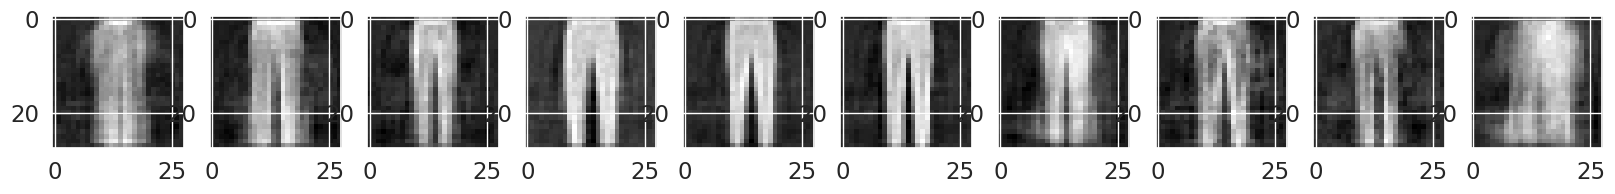

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


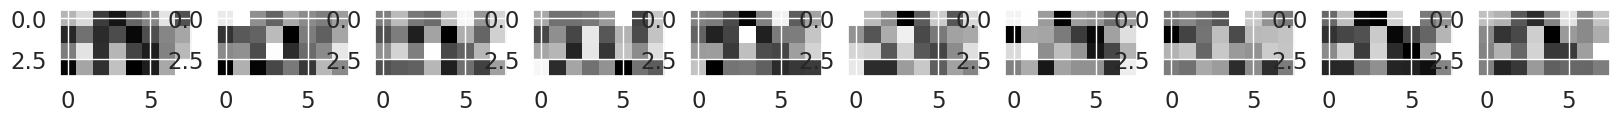

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


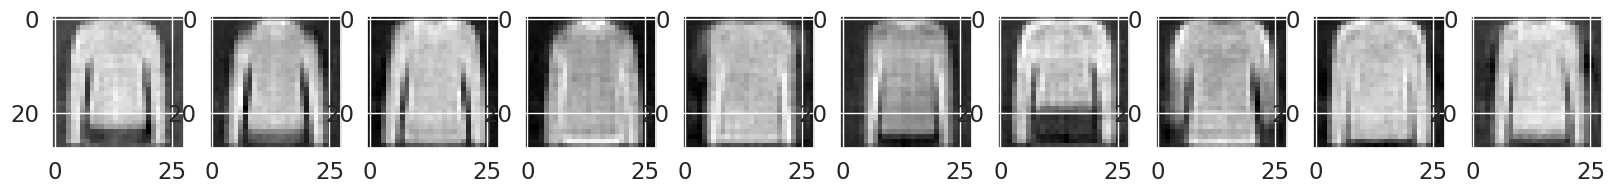

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


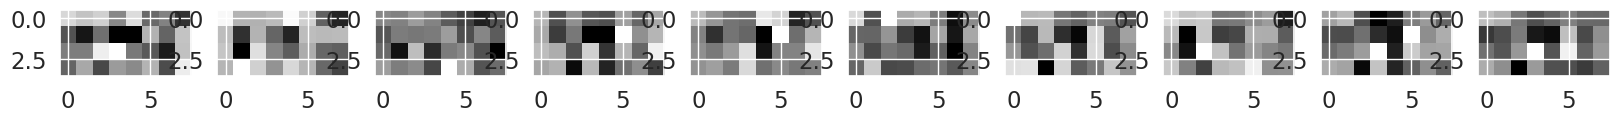

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


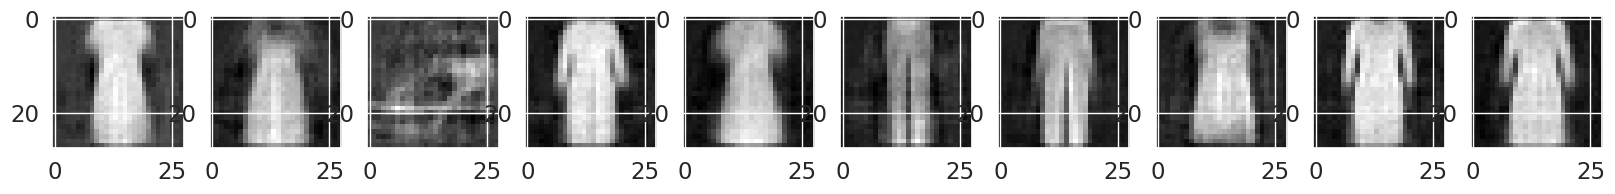

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


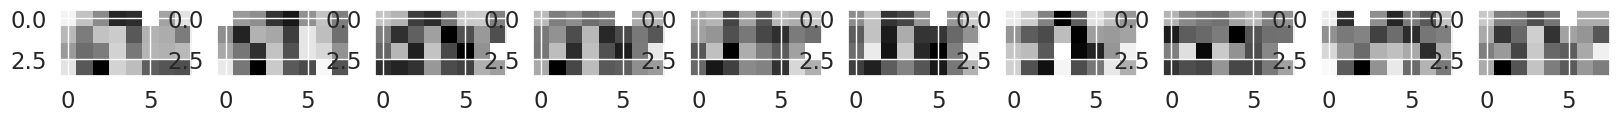

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


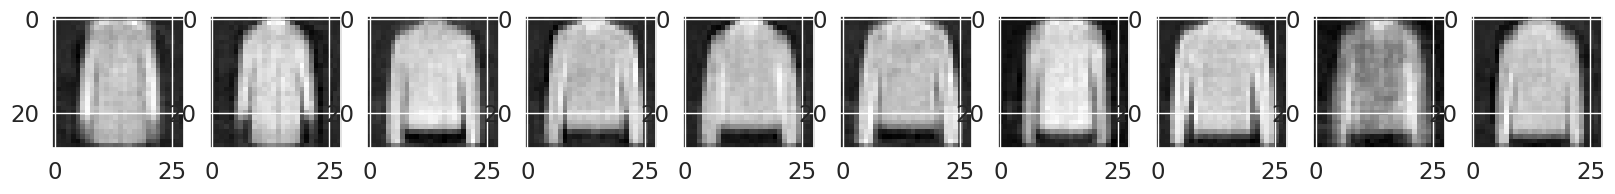

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


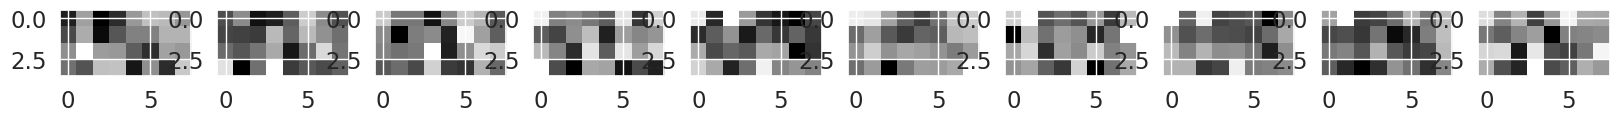

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


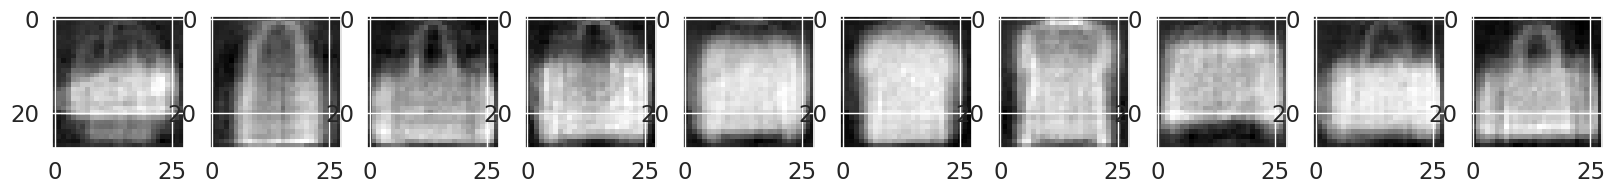

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


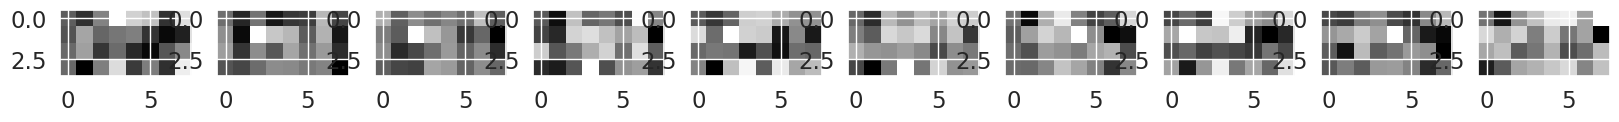

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


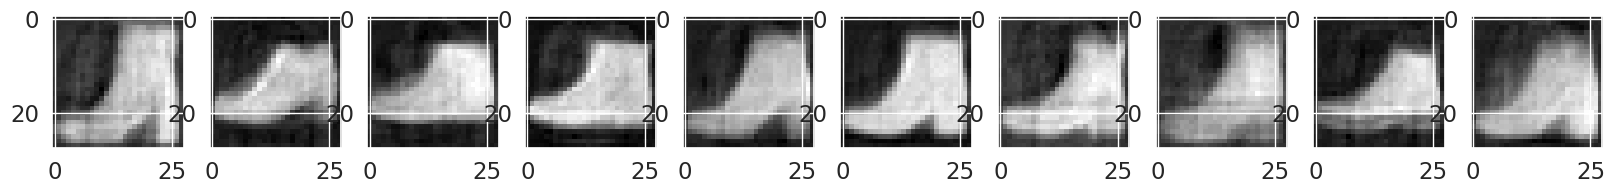

In [41]:
# CREATE 10 IMAGES for each classes;
for nb_classes in range(10):
  sub_train = np.where(train_y == nb_classes)
  images = train_x[sub_train]

          
  # CALCULATE ELLIPSOID FROM IMAGES        
  encoded_imgs = encoder.predict(images)
  sz = 4 * 8
  encoded_imgs = encoded_imgs.reshape((-1,sz))
  mm = np.mean(encoded_imgs,axis=0)
  ss = np.cov(encoded_imgs,rowvar=False)

  # GENERATE 10 RANDOM IMAGES
  generated = np.random.multivariate_normal(mm,ss,10)

  # PLOT 10 RANDOM IMAGES

  #visualisation du latent space
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  for i in range(10):
      ax[i].imshow(generated[i].reshape(4, 8),cmap='gray')
  plt.show()

  #visualisation reconstruction
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  reconstruct = decoder.predict(generated)
  for i in range(10):
      ax[i].imshow(reconstruct[i].reshape(28, 28),cmap='gray')
  plt.show()


## Convolutional AutoEncoder: before proceeding to this step, relaunch the dense auto-encoder with a latent space of dimension 30+.

In [42]:
# input layer
input_layer = Input(shape=(28, 28, 1))

#NB dimension
latent_dim = 32

x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
latent = Dense(latent_dim, name="latent")(x)
direct_input = Input(shape=(latent_dim,))

decoded = Dense(7 * 7* 32, activation="relu")(direct_input)
x = Reshape((7, 7, 32))(decoded)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)



encoder = Model(input_layer, latent)
decoder = Model(direct_input, decoder_outputs)
model = Model(input_layer, decoder(latent))

model.summary()
decoder.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 28, 28, 1)      │        80,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,145 (586.50 KB)

 Trainable params: 149,761 (585.00 KB)

 Non-trainable params: 384 (1.50 KB)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1568)           │        51,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,449 (314.25 KB)

 Trainable params: 80,257 (313.50 KB)

 Non-trainable params: 192 (768.00 B)

In [43]:
model.compile(optimizer='adam', loss='mse')
train_x2 = train_x.reshape(-1, 28, 28, 1)
val_x2 = test_x.reshape(-1, 28, 28, 1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = model.fit(train_x2, train_x2,validation_data=(val_x2, val_x2), epochs=400, batch_size=32, callbacks=[early_stopping,reduce_lr])

Epoch 1/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0590 - val_loss: 0.0893 - learning_rate: 0.0010
Epoch 2/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0178 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 3/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 4/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 5/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 6/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 7/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 8/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 9/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0104 - learning_rate: 0.0010
E

In [44]:
preds = model.predict(train_x2)
preds_latent = encoder.predict(train_x2)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


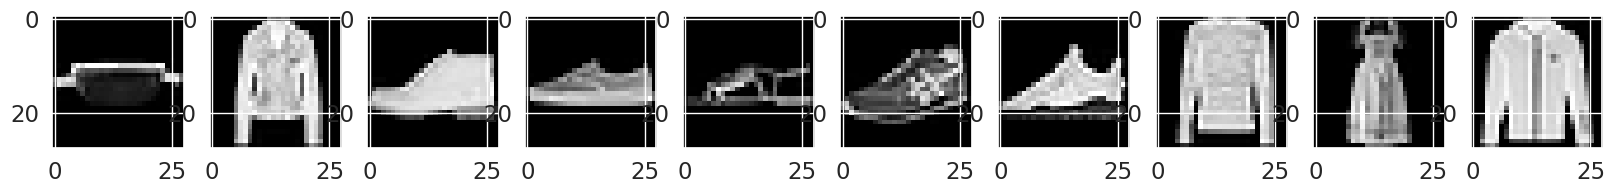

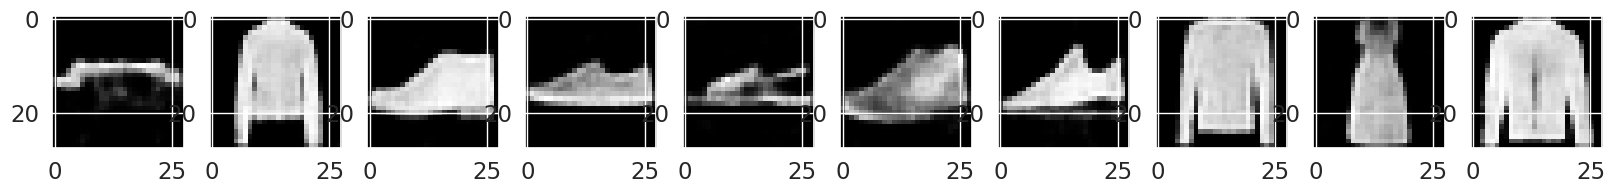

In [46]:
#images originales
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(train_x2[i].reshape(28, 28),cmap='gray')
plt.show()

#visualisation du latent space
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds_latent[i].reshape(4, 8),cmap='gray')
plt.show()

#visualisation
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28),cmap='gray')
plt.show()

In [47]:
from sklearn.manifold import TSNE

preds_latent = encoder.predict(train_x2)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(preds_latent)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 8.099275


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.739174
[t-SNE] KL divergence after 300 iterations: 3.373633


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline



import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 [Text(7.624107837677002, 4.4252848625183105, 't-shirt'),
  Text(-1.9751410484313965, 8.806869506835938, 'trouser'),
  Text(4.85487174987793, -4.7487664222717285, 'pullover'),
  Text(1.6115171909332275, 4.697650909423828, 'dress'),
  Text(5.580245018005371, -2.9417598247528076, 'coat'),
  Text(-4.42601203918457, -0.6858900785446167, 'sandal'),
  Text(4.648505687713623, -1.8722906112670898, 'shirt'),
  Text(-8.786882400512695, 2.7936129570007324, 'sneaker'),
  Text(-1.5162179470062256, -3.5881850719451904, 'bag'),
  Text(-7.696676254272461, -5.993053913116455, 'ankle boot')])

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


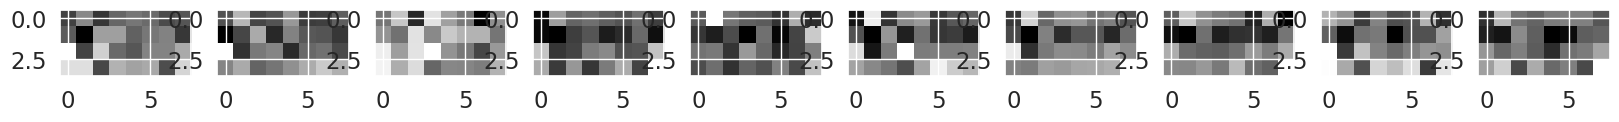

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


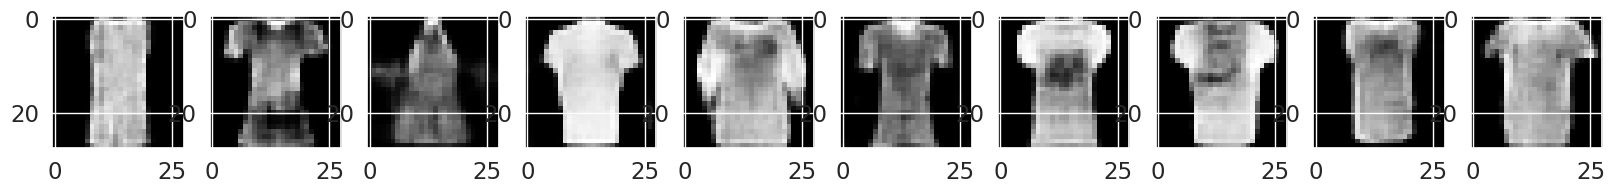

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


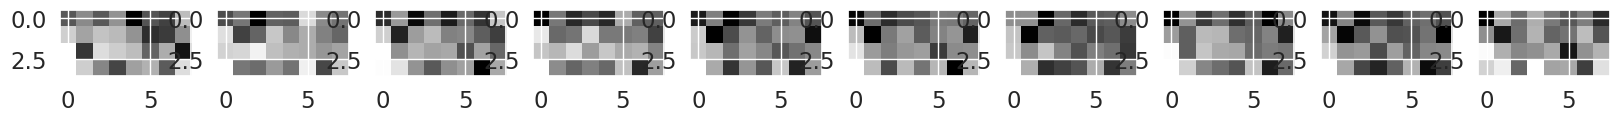

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


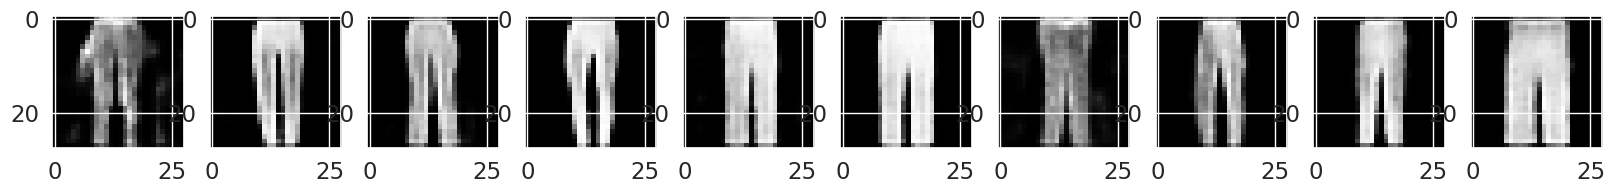

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


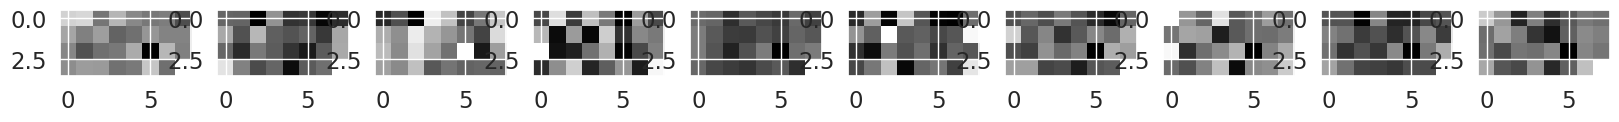

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


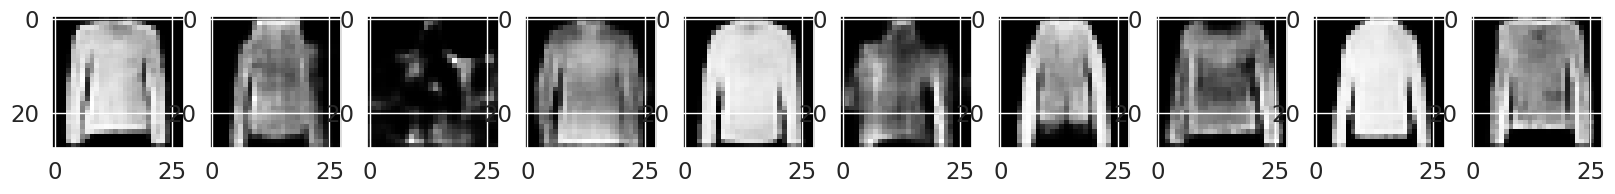

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


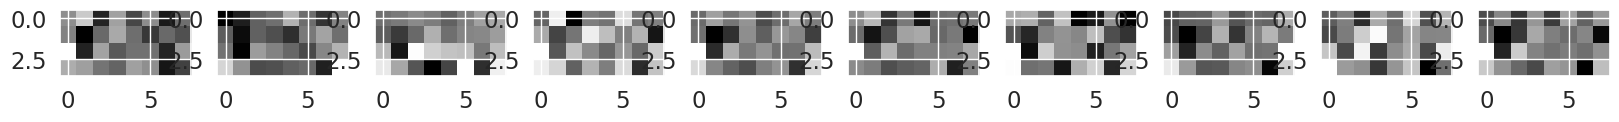

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


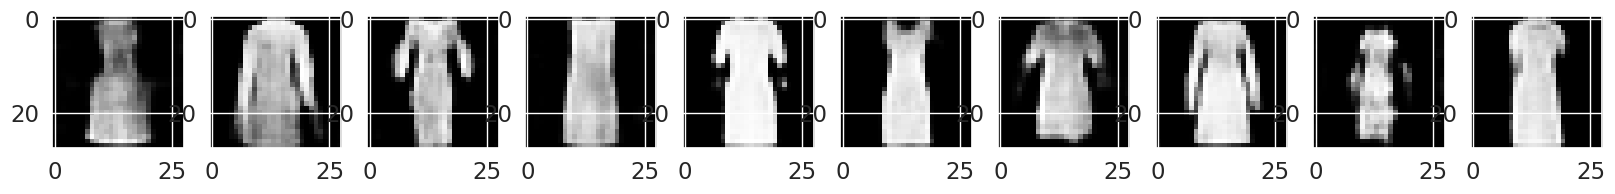

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


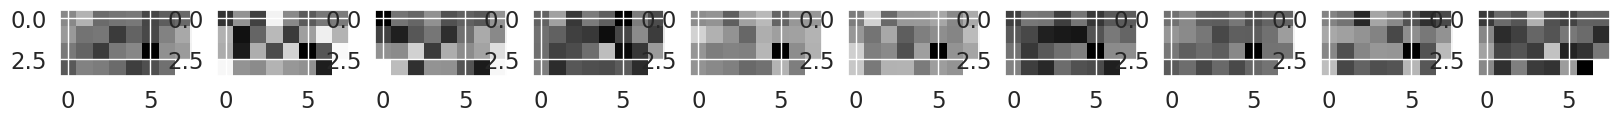

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


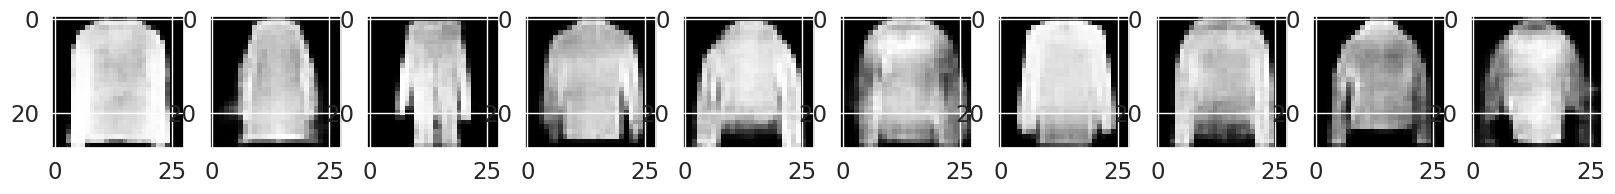

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


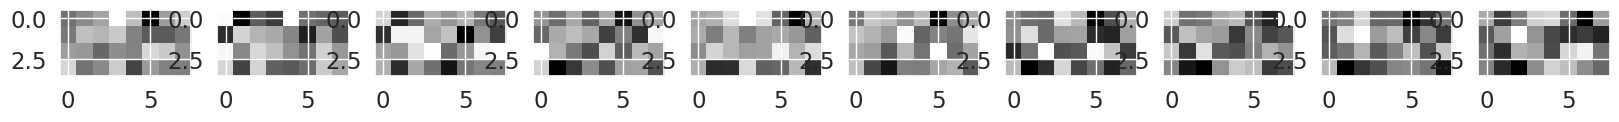

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


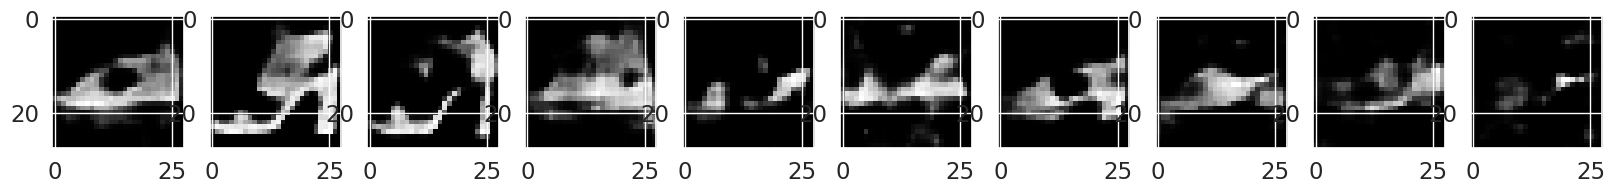

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


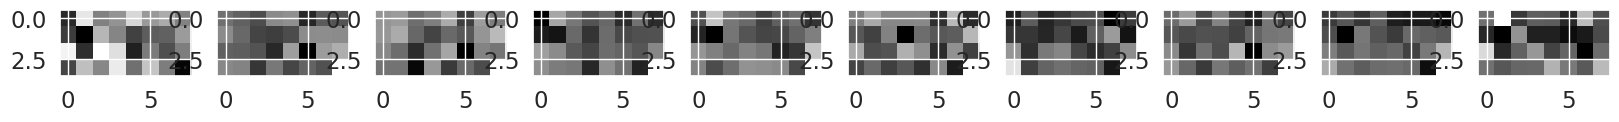

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


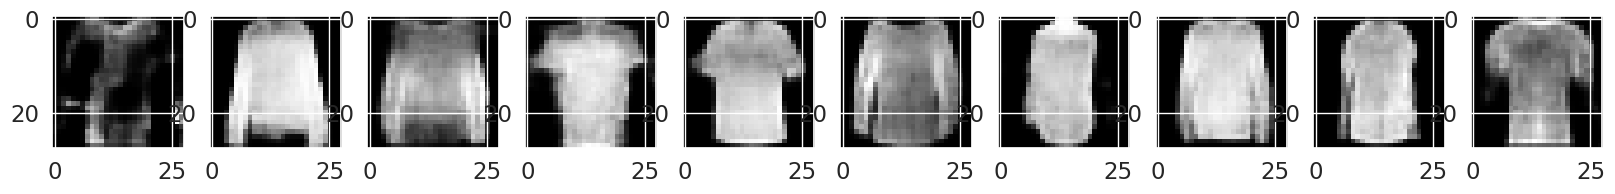

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


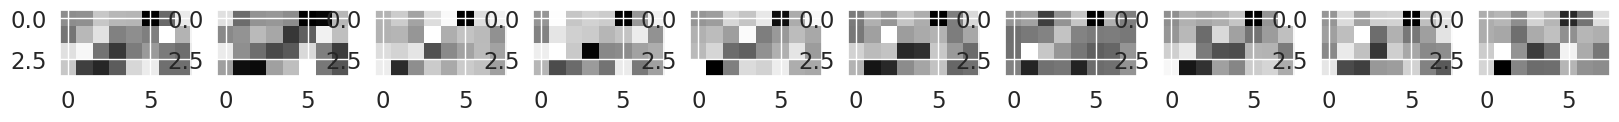

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


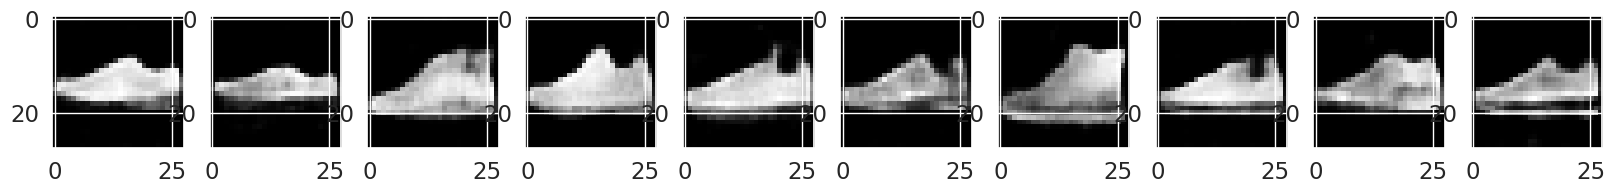

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


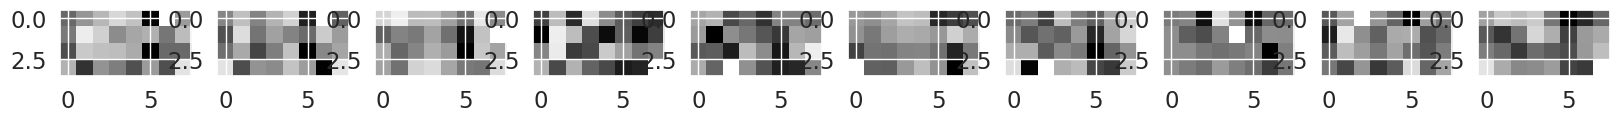

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


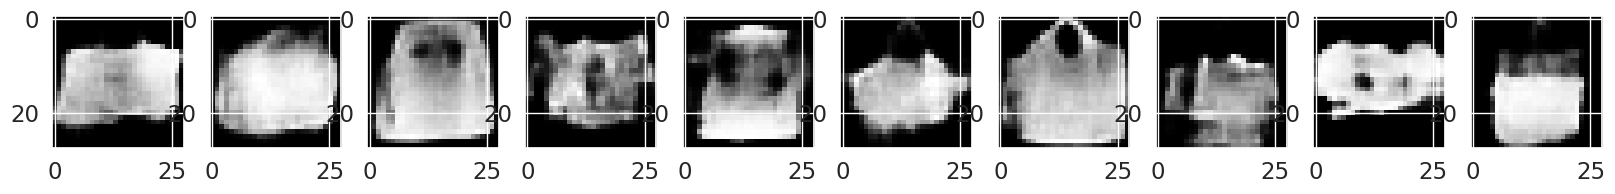

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


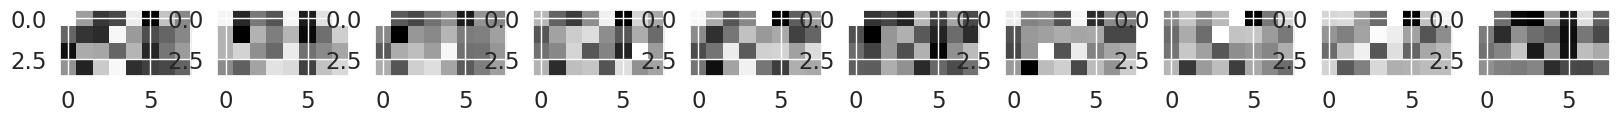

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


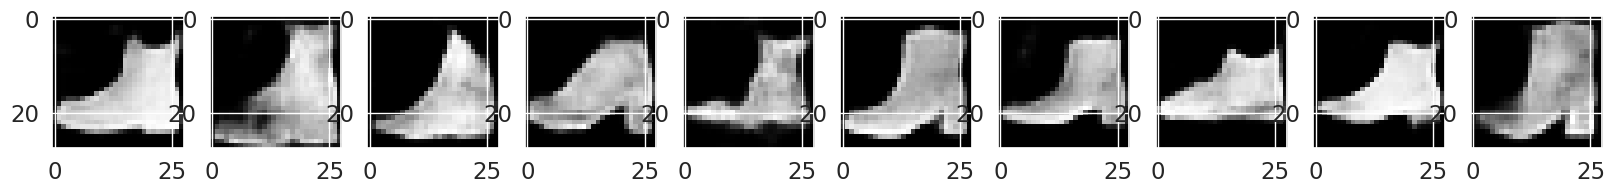

In [49]:
# CREATE 10 IMAGES for each classes;
for nb_classes in range(10):
  sub_train = np.where(train_y == nb_classes)
  images = train_x2[sub_train]

          
  # CALCULATE ELLIPSOID FROM IMAGES        
  encoded_imgs = encoder.predict(images)
  sz = 4 * 8
  encoded_imgs = encoded_imgs.reshape((-1,sz))
  mm = np.mean(encoded_imgs,axis=0)
  ss = np.cov(encoded_imgs,rowvar=False)

  # GENERATE 10 RANDOM IMAGES
  generated = np.random.multivariate_normal(mm,ss,10)

  # PLOT 10 RANDOM IMAGES

  #visualisation du latent space
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  for i in range(10):
      ax[i].imshow(generated[i].reshape(4, 8),cmap='gray')
  plt.show()

  #visualisation reconstruction
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  reconstruct = decoder.predict(generated)
  for i in range(10):
      ax[i].imshow(reconstruct[i].reshape(28, 28),cmap='gray')
  plt.show()


## Generate slightly more interesting images
Instead of choosing completely random points based on the distribution of classes in latent space, there are several ways to generate points: linear combinations of several points, choosing points close to existing training images... Let your imagination run wild.

In our case, we add a constraint on the proximity of the generated points to the initial images in latent space:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


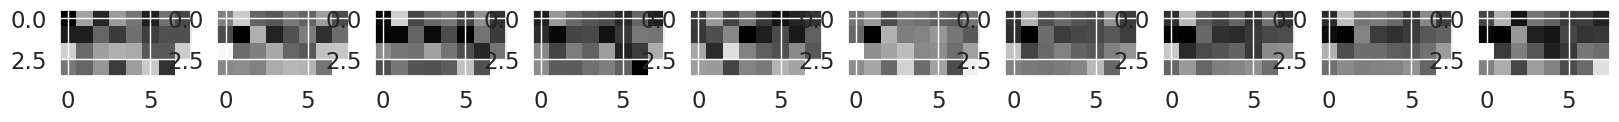

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


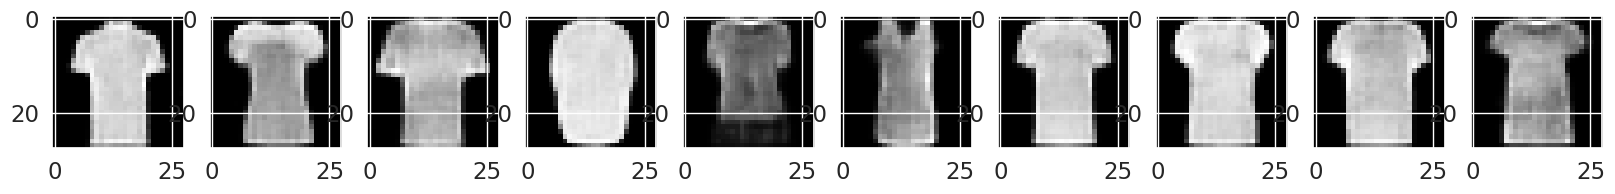

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


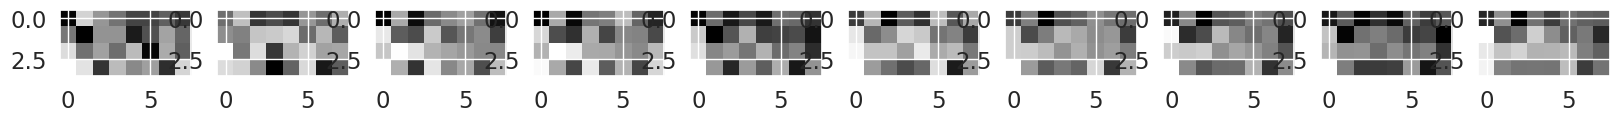

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


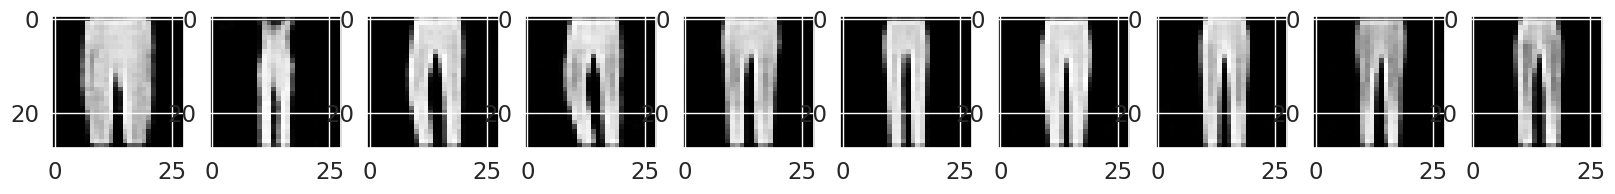

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


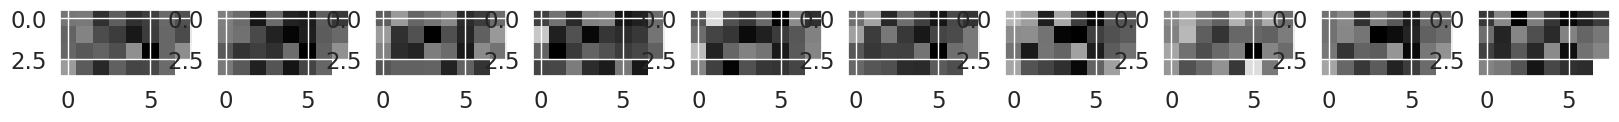

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


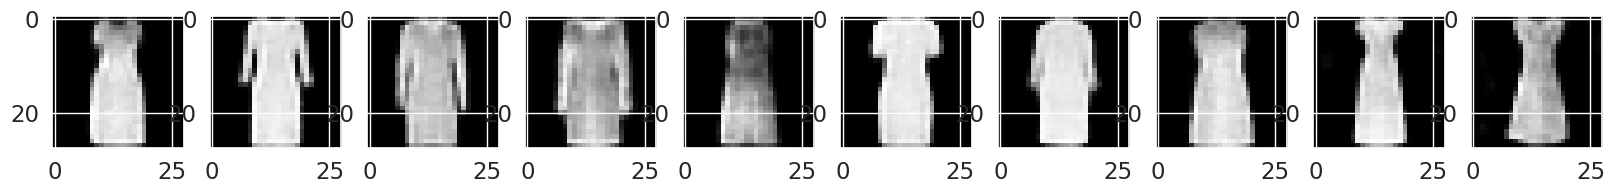

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


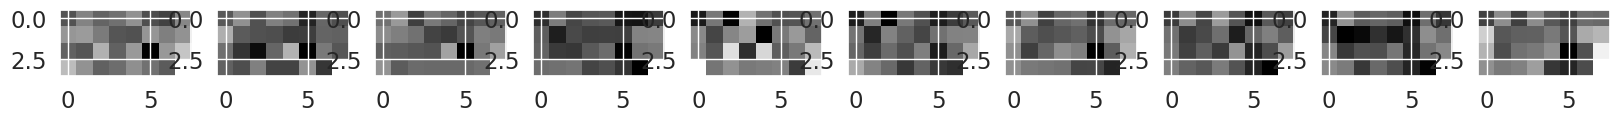

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


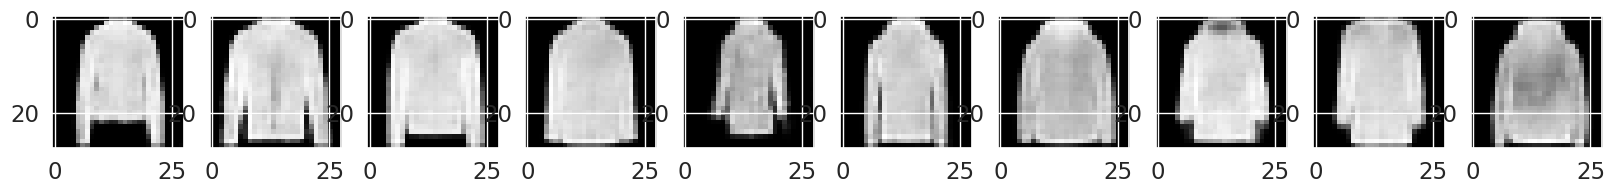

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


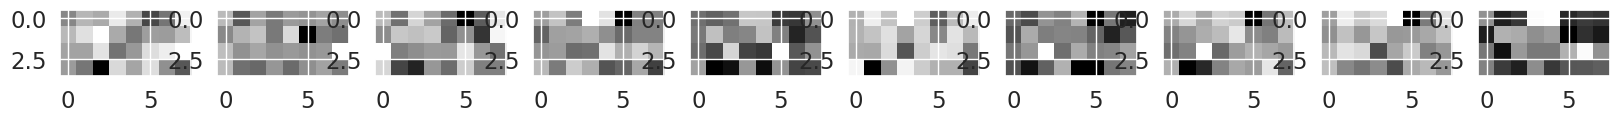

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


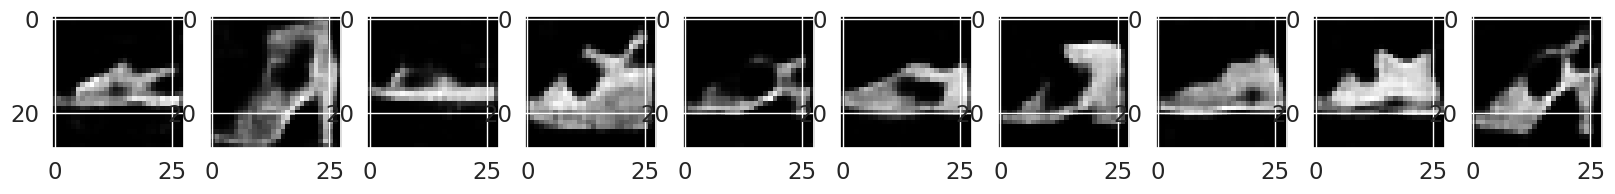

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


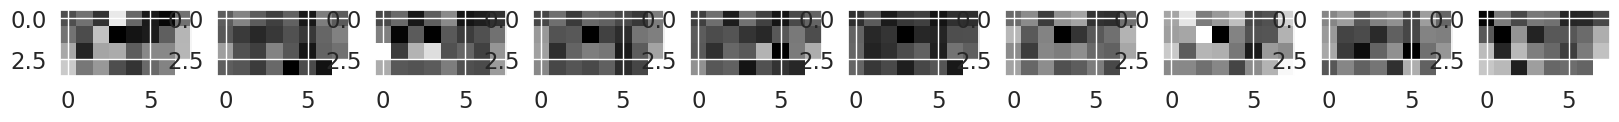

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


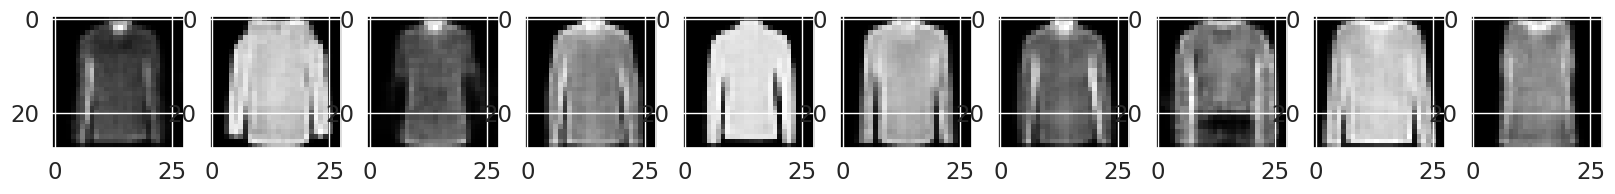

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


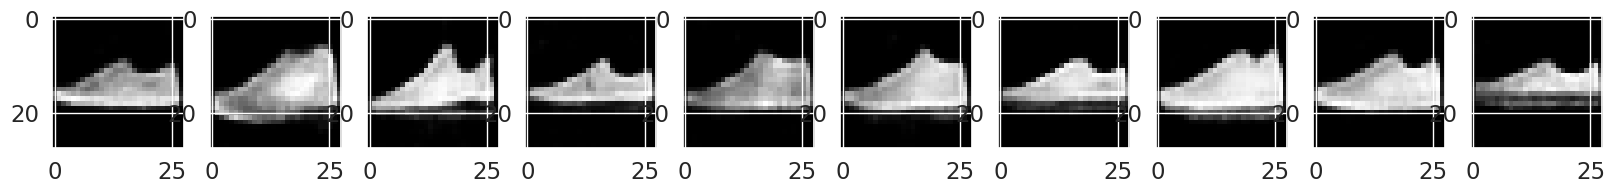

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


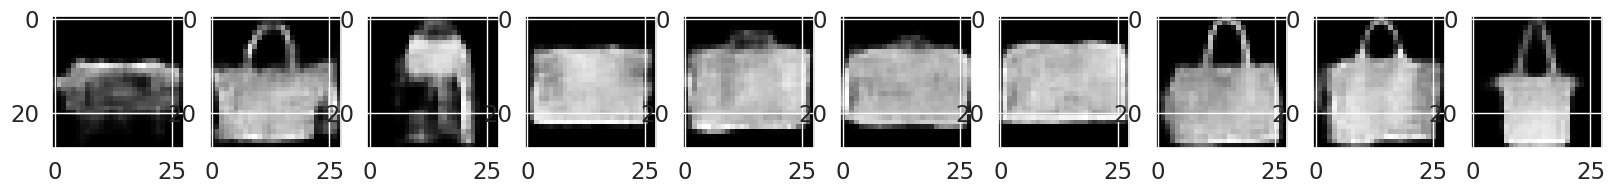

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


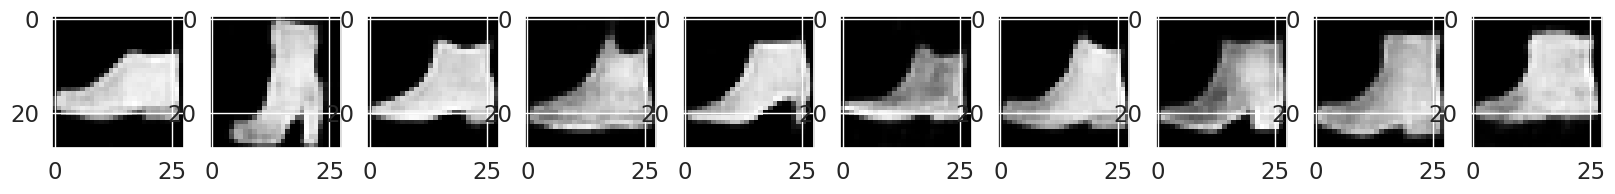

In [52]:
for nb_classes in range(10):
  sub_train = np.where(train_y == nb_classes)
  images = train_x2[sub_train]

          
  # CALCULATE ELLIPSOID FROM IMAGES        
  encoded_imgs = encoder.predict(images)
  sz = 4 * 8
  encoded_imgs = encoded_imgs.reshape((-1,sz))
  mm = np.mean(encoded_imgs,axis=0)
  ss = np.cov(encoded_imgs,rowvar=False)


  # DISTANCE TO MOVE AWAY FROM EXISTING TRAIN IMAGES
  beta = 0.2
  # GENERATE 10 Random Images in latent space
  generated = np.random.multivariate_normal(mm,ss,10)
  generated = beta*generated + (1-beta)*encoded_imgs[:10]

  # PLOT 10 RANDOM IMAGES

  #visualisation du latent space
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  for i in range(10):
      ax[i].imshow(generated[i].reshape(4, 8),cmap='gray')
  plt.show()

  #visualisation reconstruction
  f, ax = plt.subplots(1,10)
  f.set_size_inches(20, 20)
  reconstruct = decoder.predict(generated)
  for i in range(10):
      ax[i].imshow(reconstruct[i].reshape(28, 28),cmap='gray')
  plt.show()

# Part 2: denoising AE
Various techniques exist to prevent an AE from learning the identity function in order to improve its ability to learn richer representations: by forcing the latent space to have a small number of neurons, we force the network to learn an intelligent representation of the data. There are other ways of forcing the network to learn a good representation: by adding random noise to our input data to recover the original image without this noise.

In this way, the AE can't simply copy the input and its output because the input is noisy, so we ask it to subtract the noise and understand the underlying data: this is AE denoising.

In [53]:
from imgaug import augmenters
# Lets add sample noise - Salt and Pepper
noise = augmenters.ImpulseNoise(0.3)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x2 * 255) / 255
val_x_n = seq_object.augment_images(val_x2 * 255) / 255

In [54]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28),cmap='gray')
plt.show()

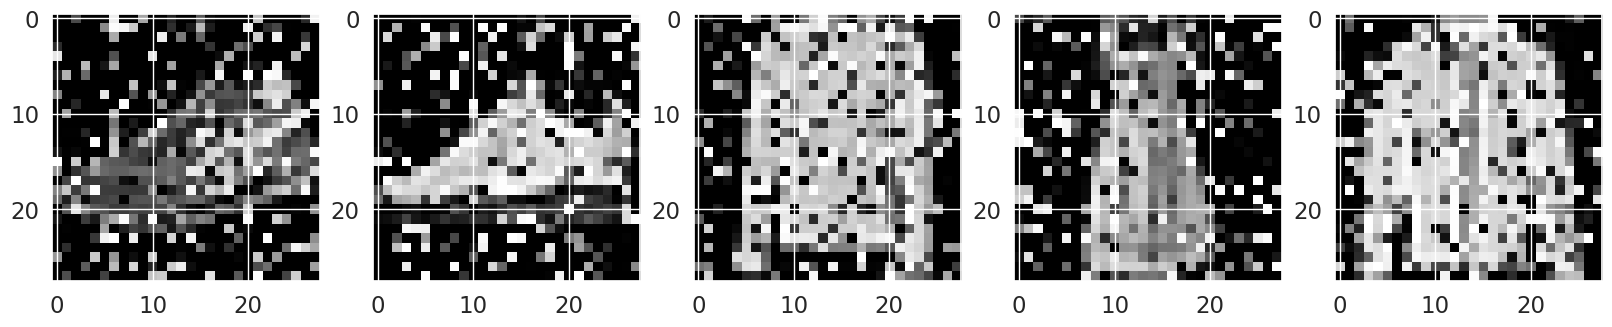

In [55]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28),cmap='gray')
plt.show()

**Re-implement a Convolutional AutoEncoder** and train it on this noisy data, following the same format, visualize the latent space obtained, visualize the reconstruction of your autoencoder and generate new data: try it with a large latent space: 30+.

You can also have fun varying the type of noise you add to the images by following the doc: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html

In [56]:
#votre code
# input layer
input_layer = Input(shape=(28, 28, 1))

#NB dimension
latent_dim = 32

x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
latent = Dense(latent_dim, name="latent")(x)
direct_input = Input(shape=(latent_dim,))

decoded = Dense(7 * 7* 32, activation="relu")(direct_input)
x = Reshape((7, 7, 32))(decoded)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)



encoder = Model(input_layer, latent)
decoder = Model(direct_input, decoder_outputs)
model = Model(input_layer, decoder(latent))

model.summary()
decoder.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 28, 28, 1)      │        80,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,145 (586.50 KB)

 Trainable params: 149,761 (585.00 KB)

 Non-trainable params: 384 (1.50 KB)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1568)           │        51,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,449 (314.25 KB)

 Trainable params: 80,257 (313.50 KB)

 Non-trainable params: 192 (768.00 B)

In [60]:
#votre code
model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = model.fit(train_x_n, train_x_n, validation_data=(val_x_n, val_x_n), epochs=400, batch_size=32, callbacks=[early_stopping,reduce_lr])


Epoch 1/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0870 - val_loss: 0.0937 - learning_rate: 0.0010
Epoch 2/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0791 - val_loss: 0.0784 - learning_rate: 0.0010
Epoch 3/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0773 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 4/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0766 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 5/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0763 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 6/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0761 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 7/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0759 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 8/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0758 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 9/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0756 - val_loss: 0.0770 - learning_rate: 0.0010
E

In [61]:
#votre code
preds = model.predict(val_x_n)
preds_latent = encoder.predict(val_x_n)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


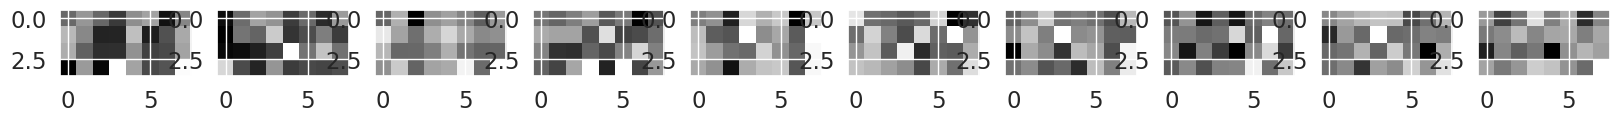

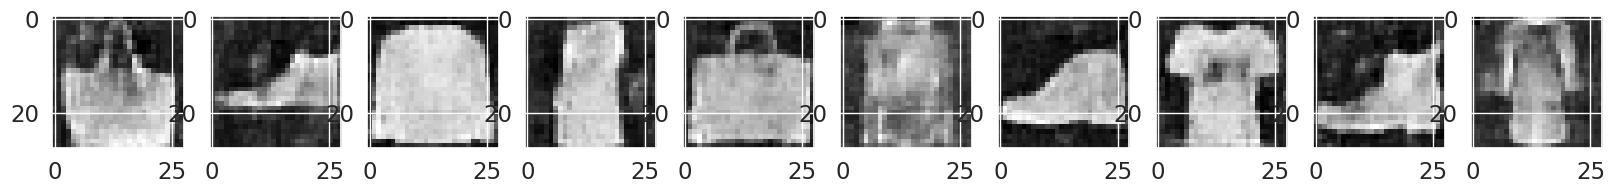

In [63]:
#votre code
#images originales
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(val_x_n[i].reshape(28, 28),cmap='gray')
plt.show()

#visualisation du latent space
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds_latent[i].reshape(4, 8),cmap='gray')
plt.show()

#visualisation
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28),cmap='gray')
plt.show()

# Part 3: Variational AE

Following the example: https://keras.io/examples/generative/vae/ , implement a variational AutoEncoder and display the generated examples on FashionMnist

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Sampling(nn.Module):
    def forward(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(64 * 7 * 7, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)

    def forward(self, z):
        x = torch.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

latent_dim = 32
batch_size = 128
epochs = 10
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device).to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 1, Loss: 309.864747265625
Epoch 2, Loss: 267.9146057291667
Epoch 3, Loss: 260.0543955729167
Epoch 4, Loss: 255.33780091145834
Epoch 5, Loss: 252.34109586588542
Epoch 6, Loss: 250.36172919921876
Epoch 7, Loss: 248.92675657552084
Epoch 8, Loss: 247.83760384114584
Epoch 9, Loss: 246.97906673177084
Epoch 10, Loss: 246.3631423502604


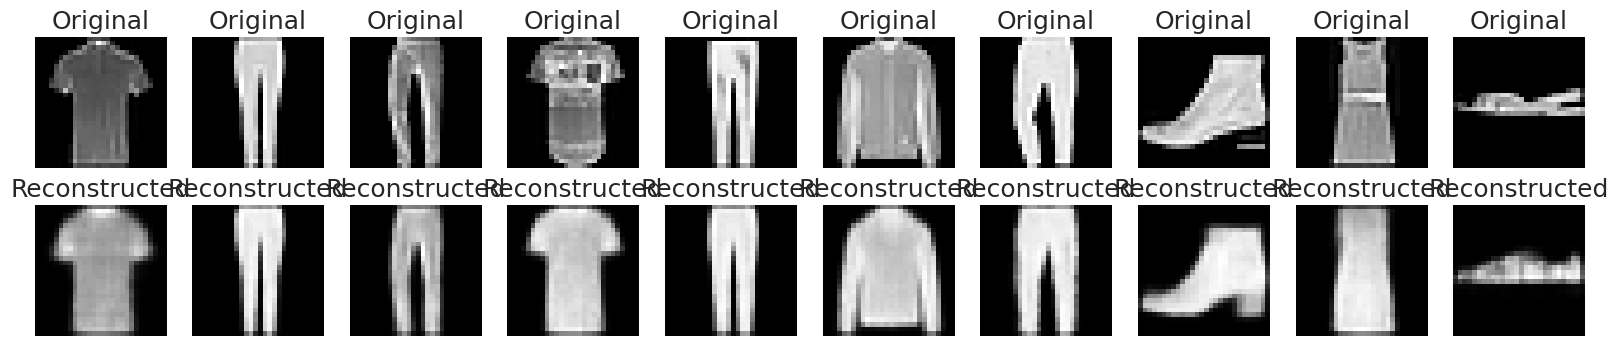

In [ ]:
def show_images(original, reconstructed, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.eval() 
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device).to(torch.float32)
        reconstructed, _, _ = model(data)
        data = data.cpu()
        reconstructed = reconstructed.cpu()
        show_images(data, reconstructed)
        break

In [71]:
device

device(type='cuda')

# Part 4: GANs



**Generative Adversarial Networks** (GANs); imitation game played by a G generator and a D discriminator.

You will discover:

* the original GAN framework proposed by [GoodFellow et al. in 2014] (https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

* some basic techniques for reducing the collapse mode while improving the quality and convergence speed of generated examples

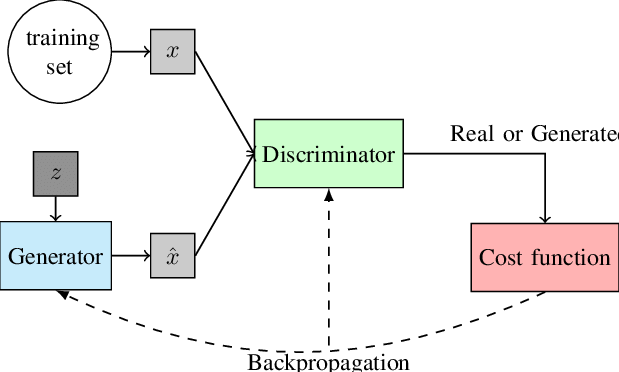


GANs consist of two components:


* Generator - generates new data instances
* Discriminator - attempts to distinguish generated or fake data from the real dataset.

## Principle

The Generator is fed with noise in the form of a random distribution and generates false data from this noise. The falsified data from the generator is fed into the discriminator. Once training is complete, the generator should be able to generate real data from the noise.

The discriminator becomes the generator's adversary. This is essentially a classifier or discriminator whose function is to distinguish between two different classes of data. In this case, the classes are the real data (denoted by 1) and the false data produced by the generator (denoted by 0).


The interesting thing about this approach is that the generator learns to produce meaningful images without ever having seen the real images.

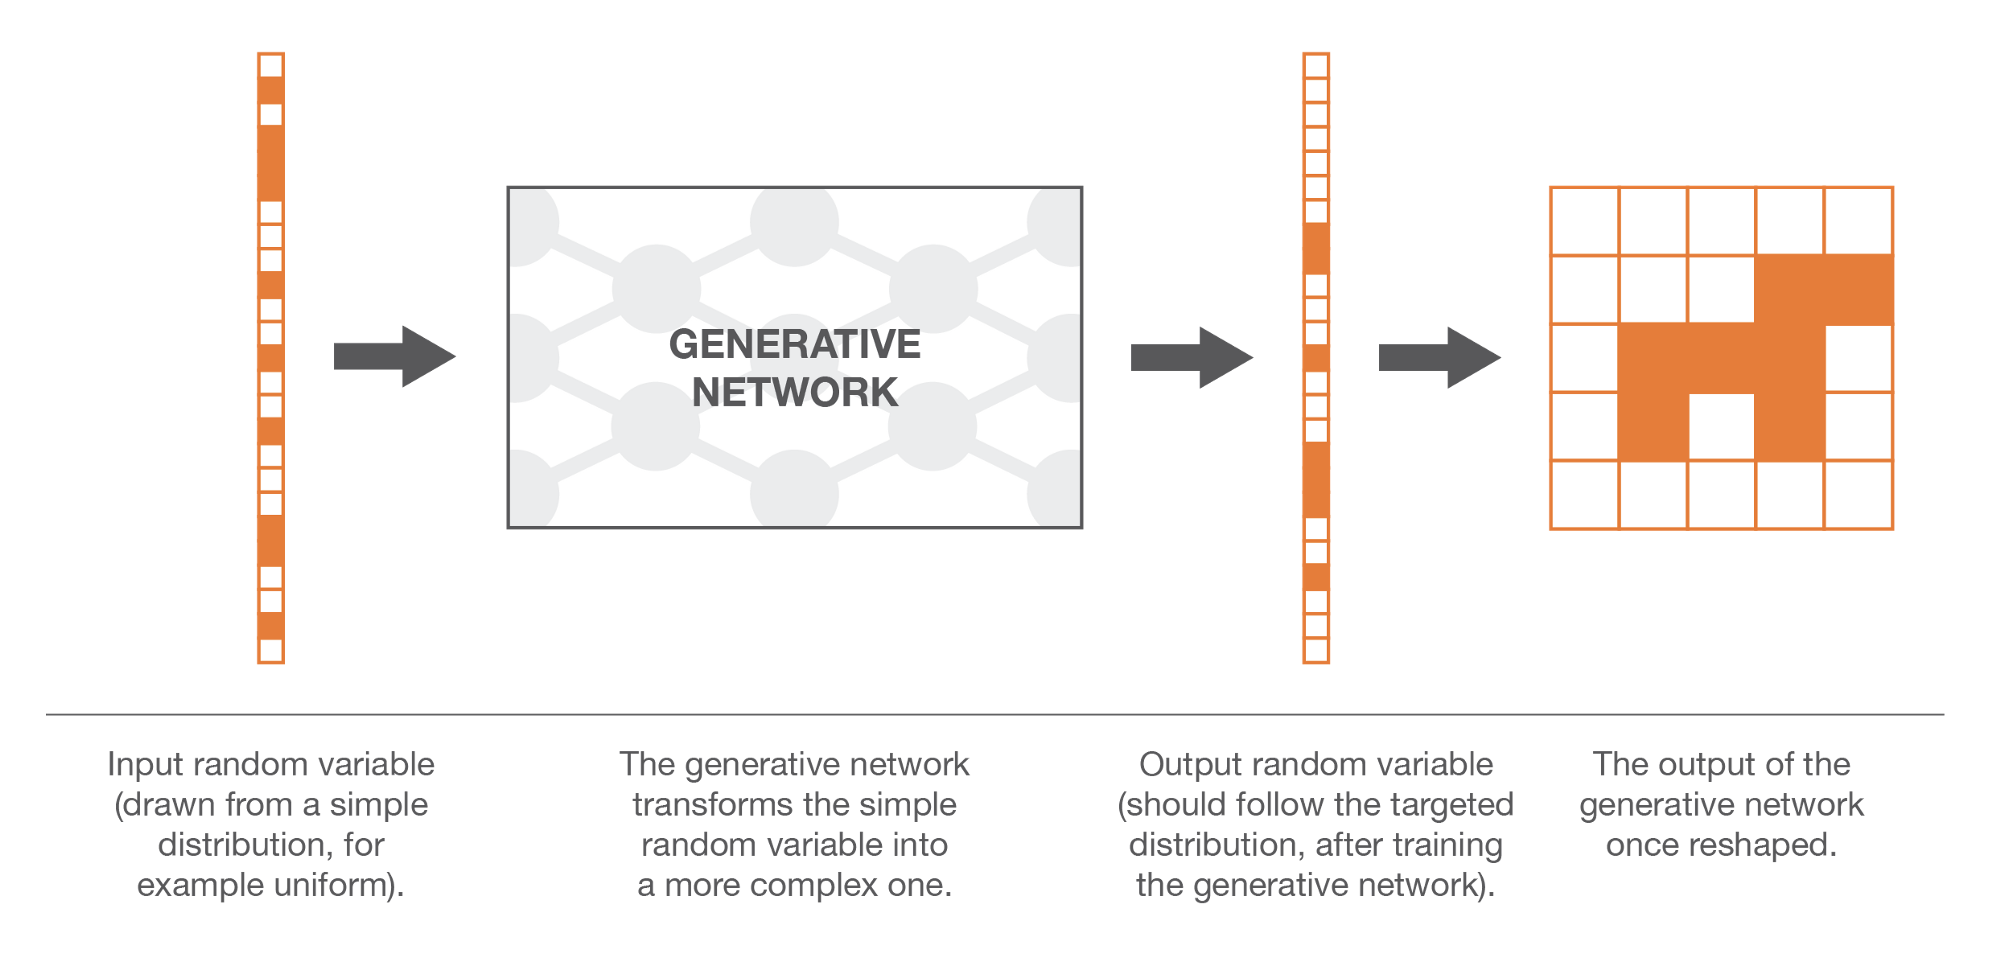

## Classic GANs and their implementation

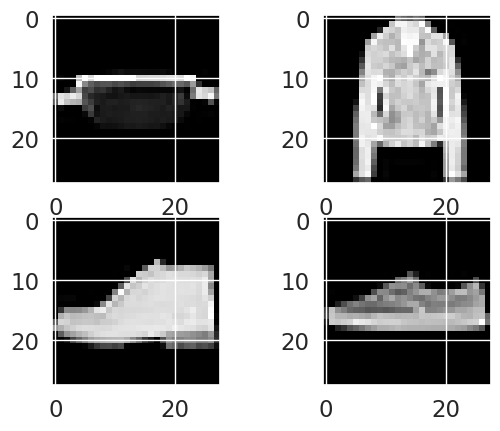

In [72]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(train_x[idx].reshape(28,28),cmap='gray')
        idx+=1


Simple GAN model (dense)

In [83]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [84]:
generator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 512)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,656 (1.22 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [85]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [86]:
discriminator.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,179 (946.01 KB)

 Trainable params: 242,179 (946.01 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [88]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 28, 28, 1)      │       320,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 1)              │       242,179 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,835 (2.15 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 243,971 (953.01 KB)

In [89]:
epochs = 120
batch_size = 100
noise_shape=100

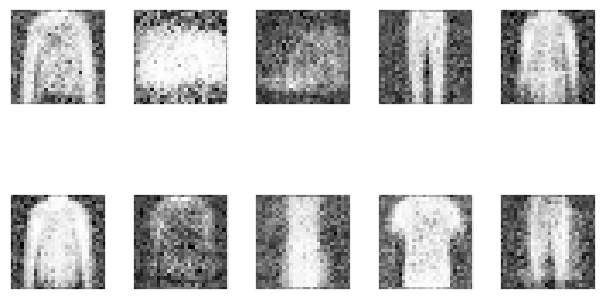

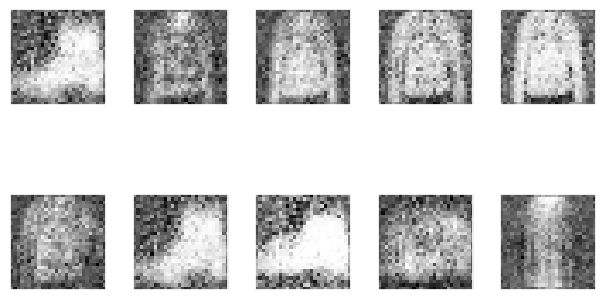

Training is complete


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.Linear(128, 784),
            nn.Tanh() 
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# [begin]
generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 120
batch_size = 100
noise_shape = 100

for epoch in range(epochs):
    for i in range(train_x2.shape[0] // batch_size):
        # Train Discriminator
        discriminator.train()

        real_images = torch.tensor(train_x2[i * batch_size:(i + 1) * batch_size]).float().cuda()
        real_labels = torch.ones(batch_size, 1).cuda()
        
        optimizer_d.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()
        
        noise = torch.randn(batch_size, noise_shape).cuda()
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).cuda()
        
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        
        optimizer_d.step()
        
        generator.train()
        optimizer_g.zero_grad()
        
        noise = torch.randn(batch_size, noise_shape).cuda()
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        
        optimizer_g.step()
    
    if epoch % 20 == 0:
        generator.eval()
        with torch.no_grad():
            samples = 10
            noise = torch.randn(samples, noise_shape).cuda()
            x_fake = generator(noise).cpu().numpy()

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

print('Training is complete')


In [98]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator(torch.tensor(noise, dtype=torch.float32).to(device))

Text(0.5, 1.0, 'How the noise looks')

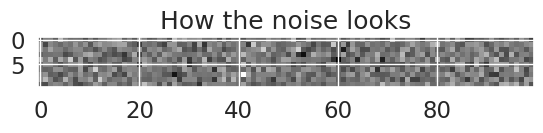

In [99]:
plt.imshow(noise, cmap='gray')
plt.title('How the noise looks')

In [103]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28).detach().to('cpu').numpy(),cmap='gray')
         idx+=1

## Problems with Classic GANs

In practice, GANs suffer from many problems, especially during training. A common problem is that the generator collapses to produce a single sample or a small family of very similar samples (as you can see here). In this case, the generator learns to fool the discriminator with a single image or a few images into believing that it is a real image. Another mode involves the generator and discriminator oscillating during training, rather than converging on a fixed point. Furthermore, if one agent becomes much more powerful than the other, the other agent's training signal becomes useless, and the system doesn't learn. There are many tricks to training GANs, one of which is the use of deep convolution generator networks: https://arxiv.org/abs/1511.06434

## Implementation

From the following resource: https://github.com/SK7here/DCGAN-Fashion-MNIST/blob/master/DCGAN-Model.ipynb

Implement a DC-GAN for FashionMNIST data generation

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

batch_size = 128
lr = 0.0002
epochs = 20
noise_dim = 100
image_size = 28
channels = 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        current_batch_size = images.size(0)
        
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        discriminator.zero_grad()
        
        real_images = images.to(device)
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(current_batch_size, noise_dim, 1, 1).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_d.step()

        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item():.4f}, g_loss: {g_loss.item():.4f}')

    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(25, noise_dim, 1, 1).to(device)
            fake_images = generator(noise).detach().cpu()
            plt.figure(figsize=(5, 5))
            for k in range(25):
                plt.subplot(5, 5, k+1)
                plt.imshow(fake_images[k].squeeze(), cmap='gray')
                plt.axis('off')
            plt.show()

print('Training complete.')


Epoch [1/20], d_loss: 0.6250, g_loss: 1.5624
Epoch [2/20], d_loss: 0.8532, g_loss: 2.3535
Epoch [3/20], d_loss: 1.0589, g_loss: 0.8862
Epoch [4/20], d_loss: 1.0209, g_loss: 1.2680
Epoch [5/20], d_loss: 1.1870, g_loss: 0.7330
Epoch [6/20], d_loss: 1.1560, g_loss: 0.9978
Epoch [7/20], d_loss: 1.0115, g_loss: 1.5285
Epoch [8/20], d_loss: 1.0038, g_loss: 1.0053
Epoch [9/20], d_loss: 0.9912, g_loss: 1.1468
Epoch [10/20], d_loss: 0.9351, g_loss: 1.0707


Epoch [11/20], d_loss: 1.2457, g_loss: 0.6437
Epoch [12/20], d_loss: 1.0463, g_loss: 0.7916
Epoch [13/20], d_loss: 0.9557, g_loss: 1.4724
Epoch [14/20], d_loss: 0.8953, g_loss: 1.5056
Epoch [15/20], d_loss: 0.8483, g_loss: 1.5361
Epoch [16/20], d_loss: 0.8695, g_loss: 1.5084
Epoch [17/20], d_loss: 1.0125, g_loss: 0.8555
Epoch [18/20], d_loss: 1.1043, g_loss: 2.0978
Epoch [19/20], d_loss: 0.9313, g_loss: 1.5563
Epoch [20/20], d_loss: 0.9022, g_loss: 1.3047


Training complete.


# References
https://arxiv.org/abs/1406.2661 - GANs paper in 2014 by Ian J. Goodfellow et al.

https://arxiv.org/abs/1511.06434 - DCGANs in 2016

https://arxiv.org/pdf/1611.02163.pdf - 2017 ICLR paper

https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29 

# Further information

So far, we've only evaluated the generated instances visually, what if you train an AE / GAN to generate new data and use this data with a convolutional network for MNIST data classification on test-set compared to real data?

A very good Machine Learning channel to follow and a video on GANs: https://www.youtube.com/watch?v=eyxmSmjmNS0

And an ongoing GAN competition to transform photos into Monet paintings: https://www.kaggle.com/c/gan-getting-started , if you have the time and inclination, this could be of interest to you!